Using device: cuda

Preparing dataset...
Found 14 classes: ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']
Train: 24235 images
Validation: 3589 images
Test: 7176 images

Creating EfficientNet-B1 model...

Training model...
Epoch 1/25, Train Loss: 1.9649, Train Acc: 34.91%, Val Loss: 1.7905, Val Acc: 43.22%
Model improved! Saved to C:\projects_ml\Radi_Assist\models\best_model.pth
Epoch 2/25, Train Loss: 1.4810, Train Acc: 50.98%, Val Loss: 1.8273, Val Acc: 44.75%
Model improved! Saved to C:\projects_ml\Radi_Assist\models\best_model.pth
Epoch 3/25, Train Loss: 1.1751, Train Acc: 61.32%, Val Loss: 1.8334, Val Acc: 47.59%
Model improved! Saved to C:\projects_ml\Radi_Assist\models\best_model.pth
Epoch 4/25, Train Loss: 0.9580, Train Acc: 68.02%, Val Loss: 1.8325, Val Acc: 49.35%
Model improved! Saved to C:\projects_ml\Radi_Assist\models\best_model.pth

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15784\480369562.py:194: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(Config.MODEL


Evaluating model on test data...
Test Accuracy: 72.37%

Classification Report:
                    precision    recall  f1-score   support

       Atelectasis       0.46      0.59      0.52       500
      Cardiomegaly       0.80      0.88      0.84       515
     Consolidation       0.64      0.70      0.67       473
             Edema       0.78      0.81      0.79       504
          Effusion       0.54      0.72      0.62       500
         Emphysema       0.80      0.79      0.80       539
          Fibrosis       0.73      0.69      0.71       523
            Hernia       0.99      0.88      0.93       573
      Infiltration       0.51      0.43      0.46       500
              Mass       0.75      0.70      0.72       507
            Nodule       0.74      0.68      0.71       493
Pleural_Thickening       0.74      0.71      0.73       508
         Pneumonia       0.97      0.78      0.86       553
      Pneumothorax       0.82      0.73      0.77       488

          accuracy

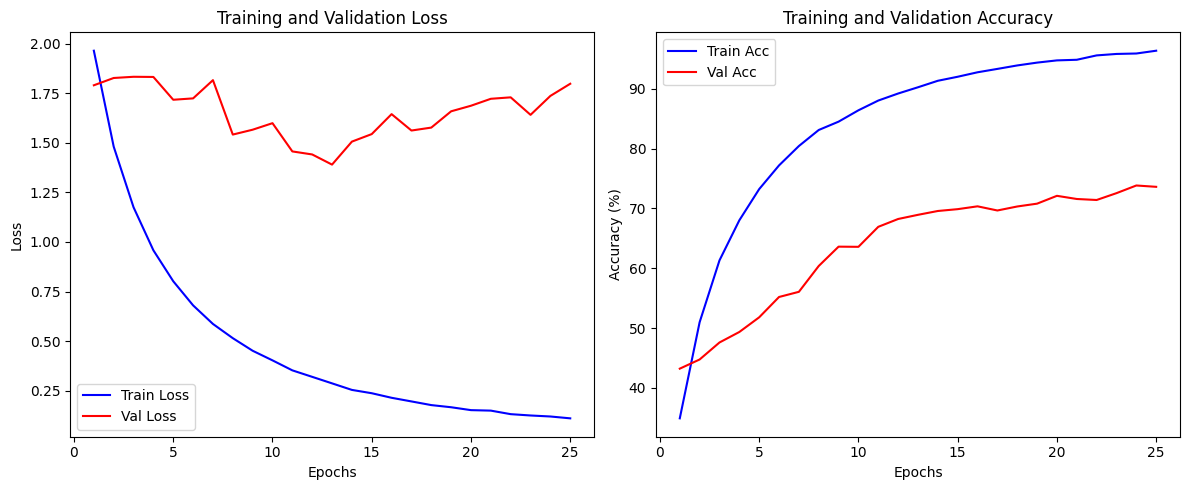

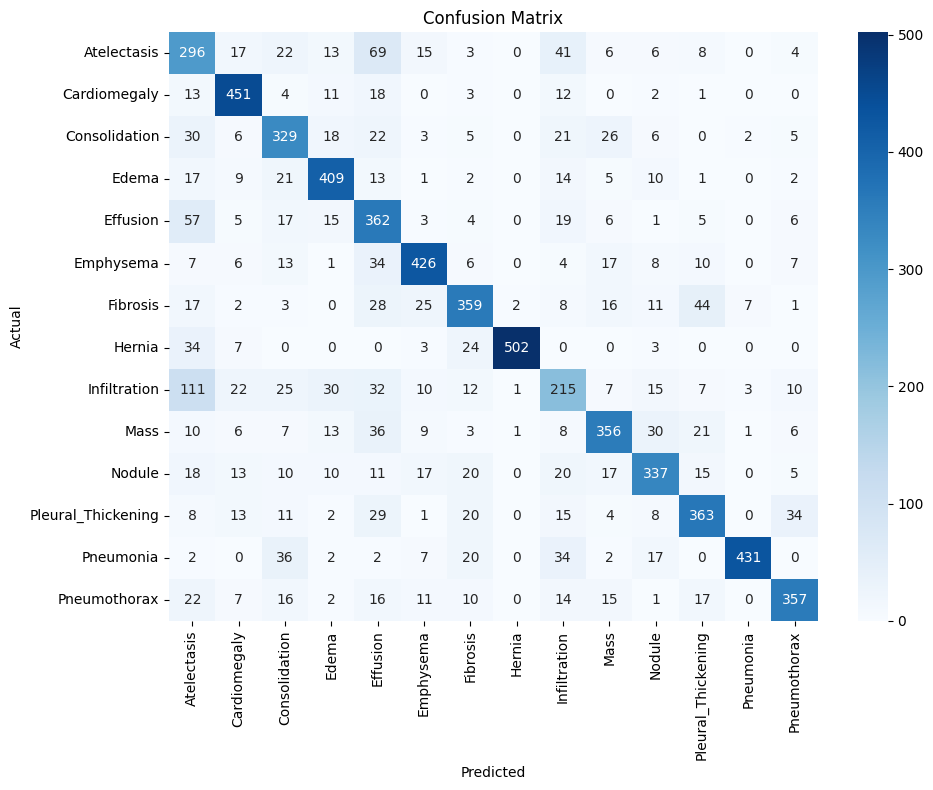

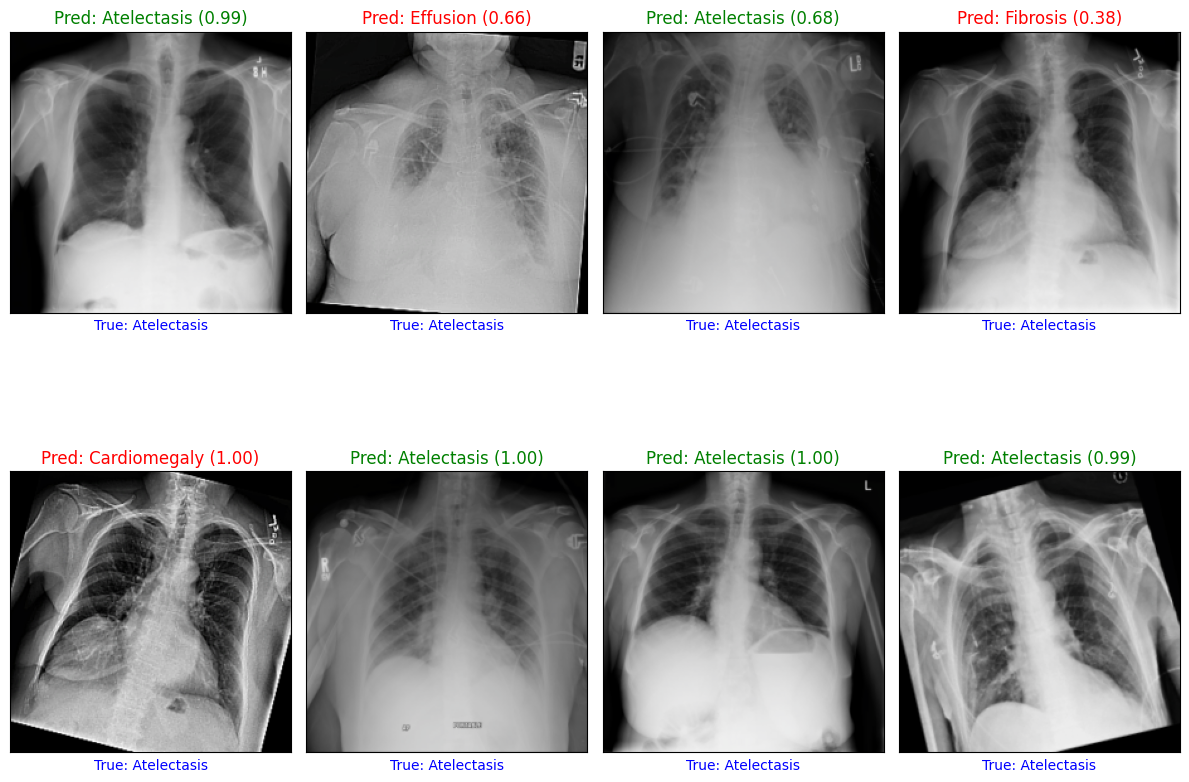

In [2]:
import os
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as T
from torch.utils.data import DataLoader, random_split
from torch.optim import Adam
from torchvision.datasets import ImageFolder
from torchvision.models import efficientnet_b1, EfficientNet_B1_Weights
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Simplified configuration
class Config:
    BASE_DIR = r"C:\projects_ml\Radi_Assist"  # Current directory
    DATA_DIR = os.path.join(BASE_DIR, "data")
    MODEL_DIR = os.path.join(BASE_DIR, "models")
    RESULTS_DIR = os.path.join(BASE_DIR, "results")
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    BATCH_SIZE = 8
    NUM_EPOCHS = 25
    LEARNING_RATE = 0.0001
    IMG_SIZE = 224
    SEED = 42
    
    @classmethod
    def create_directories(cls):
        os.makedirs(cls.MODEL_DIR, exist_ok=True)
        os.makedirs(cls.RESULTS_DIR, exist_ok=True)
        os.makedirs(os.path.join(cls.RESULTS_DIR, "plots"), exist_ok=True)

# Set random seeds for reproducibility
def set_seeds(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

def prepare_data():
    print("\nPreparing dataset...")
    
    # Define transformations for all data
    train_transform = T.Compose([
        T.Resize((Config.IMG_SIZE, Config.IMG_SIZE)),
        T.RandomHorizontalFlip(),
        T.RandomRotation(10),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    eval_transform = T.Compose([
        T.Resize((Config.IMG_SIZE, Config.IMG_SIZE)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Load all data from one directory if available, otherwise use separate directories
    if os.path.exists(os.path.join(Config.DATA_DIR, 'all')):
        # Load all data and split it
        full_dataset = ImageFolder(os.path.join(Config.DATA_DIR, 'all'), transform=None)
        
        # Split dataset: 70% train, 15% validation, 15% test
        total_size = len(full_dataset)
        train_size = int(0.7 * total_size)
        val_size = int(0.15 * total_size)
        test_size = total_size - train_size - val_size
        
        # Create splits with fixed seed for reproducibility
        train_dataset, val_dataset, test_dataset = random_split(
            full_dataset, 
            [train_size, val_size, test_size],
            generator=torch.Generator().manual_seed(Config.SEED)
        )
        
        # Apply transforms
        train_dataset.dataset.transform = train_transform
        val_dataset.dataset.transform = eval_transform
        test_dataset.dataset.transform = eval_transform
        
    else:
        # Use the existing train/val/test directory structure
        train_dataset = ImageFolder(os.path.join(Config.DATA_DIR, 'train'), transform=train_transform)
        val_dataset = ImageFolder(os.path.join(Config.DATA_DIR, 'val'), transform=eval_transform)
        test_dataset = ImageFolder(os.path.join(Config.DATA_DIR, 'test'), transform=eval_transform)
    
    # Get class names from any dataset
    class_names = train_dataset.dataset.classes if hasattr(train_dataset, 'dataset') else train_dataset.classes
    print(f"Found {len(class_names)} classes: {class_names}")
    
    # Create loaders
    train_loader = DataLoader(train_dataset, batch_size=Config.BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=Config.BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=Config.BATCH_SIZE, shuffle=False)
    
    # Print dataset statistics
    print(f"Train: {len(train_dataset)} images")
    print(f"Validation: {len(val_dataset)} images")
    print(f"Test: {len(test_dataset)} images")
    
    return train_loader, val_loader, test_loader, class_names

def create_model(num_classes):
    print("\nCreating EfficientNet-B1 model...")
    
    # Load pretrained model
    model = efficientnet_b1(weights=EfficientNet_B1_Weights.DEFAULT)
    
    # Modify classifier for our number of classes
    num_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_features, num_classes)
    
    model = model.to(Config.DEVICE)
    return model

def train_and_evaluate(model, train_loader, val_loader, test_loader, class_names):
    print("\nTraining model...")
    
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=Config.LEARNING_RATE)
    
    best_val_acc = 0.0
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    
    for epoch in range(Config.NUM_EPOCHS):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for images, targets in train_loader:
            images = images.to(Config.DEVICE)
            targets = targets.to(Config.DEVICE)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, targets)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Track statistics
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
        
        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        # Validation phase
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for images, targets in val_loader:
                images = images.to(Config.DEVICE)
                targets = targets.to(Config.DEVICE)
                
                outputs = model(images)
                loss = criterion(outputs, targets)
                
                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()
        
        val_loss = running_loss / len(val_loader)
        val_acc = 100. * correct / total
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        print(f"Epoch {epoch+1}/{Config.NUM_EPOCHS}, "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_path = os.path.join(Config.MODEL_DIR, "best_model.pth")
            torch.save(model.state_dict(), best_model_path)
            print(f"Model improved! Saved to {best_model_path}")
    
    # Load best model for final evaluation
    model.load_state_dict(torch.load(os.path.join(Config.MODEL_DIR, "best_model.pth")))
    
    # Plot learning curves
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, Config.NUM_EPOCHS+1), train_losses, 'b-', label='Train Loss')
    plt.plot(range(1, Config.NUM_EPOCHS+1), val_losses, 'r-', label='Val Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(range(1, Config.NUM_EPOCHS+1), train_accs, 'b-', label='Train Acc')
    plt.plot(range(1, Config.NUM_EPOCHS+1), val_accs, 'r-', label='Val Acc')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(os.path.join(Config.RESULTS_DIR, "plots", "learning_curves.png"))
    
    # Final evaluation on test set
    print("\nEvaluating model on test data...")
    model.eval()
    all_preds = []
    all_targets = []
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, targets in test_loader:
            images = images.to(Config.DEVICE)
            targets = targets.to(Config.DEVICE)
            
            outputs = model(images)
            _, predicted = outputs.max(1)
            
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    
    test_acc = 100. * correct / total
    print(f"Test Accuracy: {test_acc:.2f}%")
    
    # Create confusion matrix
    cm = confusion_matrix(all_targets, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.savefig(os.path.join(Config.RESULTS_DIR, "plots", "confusion_matrix.png"))
    
    # Generate classification report
    report = classification_report(all_targets, all_preds, target_names=class_names)
    print("\nClassification Report:")
    print(report)
    
    # Save report to file
    with open(os.path.join(Config.RESULTS_DIR, "classification_report.txt"), 'w') as f:
        f.write(report)
    
    # Visualize some predictions
    visualize_predictions(model, test_loader, class_names)
    
    return test_acc

def visualize_predictions(model, test_loader, class_names):
    model.eval()
    images, targets = next(iter(test_loader))
    
    with torch.no_grad():
        outputs = model(images.to(Config.DEVICE))
        probs = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)
    
    # Plot some sample predictions
    num_images = min(8, len(images))
    plt.figure(figsize=(12, 10))
    
    for i in range(num_images):
        plt.subplot(2, 4, i+1)
        
        # Convert tensor to image
        img = images[i].permute(1, 2, 0).numpy()
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
        
        plt.imshow(img)
        
        pred_idx = predicted[i].item()
        true_idx = targets[i].item()
        prob = probs[i, pred_idx].item()
        
        color = 'green' if pred_idx == true_idx else 'red'
        plt.title(f"Pred: {class_names[pred_idx]} ({prob:.2f})", color=color)
        plt.xlabel(f"True: {class_names[true_idx]}", color='blue')
        plt.xticks([])
        plt.yticks([])
    
    plt.tight_layout()
    plt.savefig(os.path.join(Config.RESULTS_DIR, "plots", "sample_predictions.png"))
    print("Sample predictions visualization saved")

def main():
    # Create directories and set seeds
    Config.create_directories()
    set_seeds(Config.SEED)
    
    print(f"Using device: {Config.DEVICE}")
    
    # Prepare data
    train_loader, val_loader, test_loader, class_names = prepare_data()
    
    # Create model
    model = create_model(len(class_names))
    
    # Train and evaluate
    test_acc = train_and_evaluate(model, train_loader, val_loader, test_loader, class_names)
    
    print("\nTraining Complete!")
    print(f"Test Accuracy: {test_acc:.2f}%")
    print(f"Model saved at: {os.path.join(Config.MODEL_DIR, 'best_model.pth')}")
    print(f"Results saved at: {Config.RESULTS_DIR}")

if __name__ == "__main__":
    main()